In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import cv2


from robot_core.orchestration.orchestrator import Orchestrator
from robot_core.utils.update_plot import update_plot

In [4]:


class TennisBallDetector:
    def __init__(self, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=100, line_distance=100):
        self.camera = cv2.VideoCapture(0)  # Adjust if necessary
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)
        self.line_distance = line_distance
        self.frame = None
        
        # Define multiple color ranges for different lighting conditions
#         self.color_ranges = [
#             (np.array([20, 40, 80]), np.array([80, 255, 255])),  # Yellow-green
#             (np.array([15, 30, 70]), np.array([85, 255, 255])),  # Broader range
#             (np.array([0, 0, 200]), np.array([180, 30, 255]))    # White range
#         ]
        
        # Create background subtractor
        #CHANGED self.bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

        if not self.camera.isOpened():
            print("Error: Could not open USB camera.")

##############################################################################
    def adjust_exposure(self, cap, target_brightness=40):
        # Read a frame to calculate the average brightness
        ret, frame = cap.read()
        if not ret:
            return
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        avg_brightness = np.mean(gray)

        
        
        # Simple proportional control
        exposure = cap.get(cv2.CAP_PROP_EXPOSURE)
        exposure_adjustment = (target_brightness - avg_brightness) / 100.0
        new_exposure = exposure + exposure_adjustment
        cap.set(cv2.CAP_PROP_EXPOSURE, new_exposure)         

    def detect(self, retry=True, max_num_retries=5, retry_interval=1):
        counter = 0
        
        while True:
            self.adjust_exposure(self.camera)
            ret, self.frame = self.camera.read()
            if not ret:
                print("Error: Failed to capture image.")
                if not retry or counter >= max_num_retries:
                    return False
                counter += 1
#                 time.sleep(retry_interval)
                continue
    
            self.last_scanned_time = time.time()
            self.frame_center = (self.frame.shape[1] // 2, self.frame.shape[0] // 2)
    
    
            print("attempting detection")
            hsv = cv2.cvtColor(self.frame, cv2.COLOR_BGR2HSV)

            # Define color ranges for tennis ball detection
            yellow_green_range = (np.array([20, 100, 100]), np.array([40, 255, 255]))
            white_range = (np.array([0, 0, 200]), np.array([180, 30, 255]))

            # Create masks for color ranges
            mask_yellow_green = cv2.inRange(hsv, *yellow_green_range)
            mask_white = cv2.inRange(hsv, *white_range)

            # Combine the masks using bitwise OR
            combined_mask = cv2.bitwise_or(mask_yellow_green, mask_white)

            # Apply Gaussian blur to the combined mask to reduce noise
            blurred_combined_mask = cv2.GaussianBlur(combined_mask, (9, 9), 2)
    
            # Apply morphological operations to clean up the mask
            kernel = np.ones((5, 5), np.uint8)
            cleaned_mask = cv2.morphologyEx(blurred_combined_mask, cv2.MORPH_CLOSE, kernel)
    
            contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
            self.balls = []

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > self.min_area:
                    perimeter = cv2.arcLength(contour, True)
                    circularity = 4 * np.pi * (area / (perimeter ** 2))
                    if circularity > 0.7:  # Enforce circularity check
                        (x, y), radius = cv2.minEnclosingCircle(contour)
                        if self.min_radius < radius < self.max_radius:
                            self.balls.append(((int(x), int(y)), int(radius)))
            
            if self.balls:
                self.display_frame()
                return True
            
            if not retry or counter >= max_num_retries:
                return False
            
            counter += 1
#             time.sleep(retry_interval)       
        

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def get_ball_vertical_y(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            return self.balls[ball_index][0][1]
        else:
            return None
        
    def draw_balls(self, frame=None):
        if frame is None:
            frame = self.frame
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time

    def draw_vertical_lines(self, frame=None):
        if frame is None:
            frame = self.frame
        height, width = frame.shape[:2]
        left_x = width // 2 - self.line_distance // 2
        right_x = width // 2 + self.line_distance // 2
        
        cv2.line(frame, (left_x, 0), (left_x, height), (255, 0, 0), 2)
        cv2.line(frame, (right_x, 0), (right_x, height), (255, 0, 0), 2)
        
        return frame

    def is_ball_between_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, ball_radius = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            return (left_x <= ball_center[0] - ball_radius) and (ball_center[0] + ball_radius <= right_x)
        else:
            return False

    def get_ball_distance_from_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, _ = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            if ball_center[0] < left_x:
                return -(left_x - ball_center[0])
            elif ball_center[0] > right_x:
                return ball_center[0] - right_x
            else:
                return 0  # Ball is between the lines
        else:
            return None

    def set_line_distance(self, distance):
        self.line_distance = distance

    def display_frame(self):
        if self.frame is not None:
            frame_with_balls = self.draw_balls()
            frame_with_lines = self.draw_vertical_lines(frame_with_balls)
            frame_rgb = cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB)
#             display.clear_output(wait=True)
            plt.imshow(frame_rgb)
            plt.show()

In [8]:
orchestrator = Orchestrator()
orchestrator.start(detector=TennisBallDetector())


Initialising robot.
Initialising controller.
Initialising tennis ball detector.
Initialising tentacle planner.
Moving to next scanning position: col: 0, row: 0
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles
tentacles


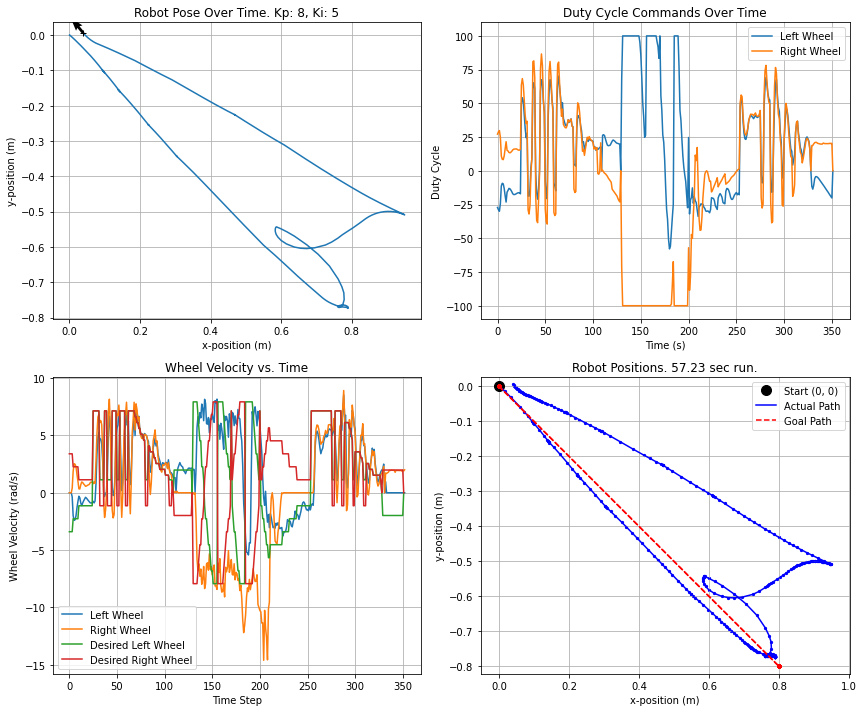

In [9]:


# Set up the plot
%matplotlib inline
plt.ion()  # Turn on interactive mode

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Main loop for updating the plot
try:
    while True:
        pass
#         update_plot(orchestrator, fig, axes)
#         time.sleep(3)  # Update plot every 3 seconds
except KeyboardInterrupt:
    print("Stopping the simulation...")
finally:
    orchestrator.stop()
    update_plot(orchestrator, fig, axes)
    plt.close(fig)


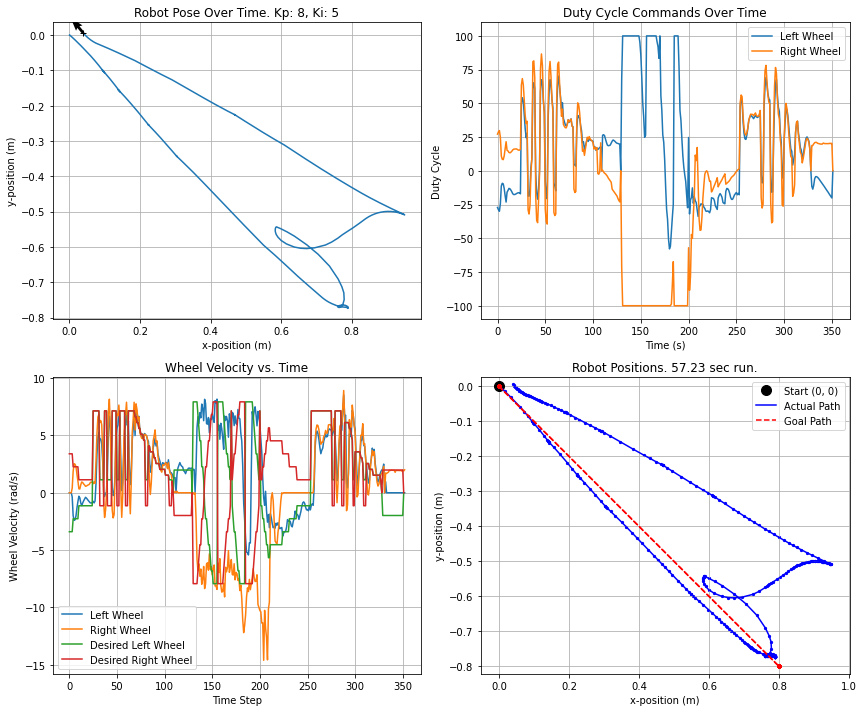

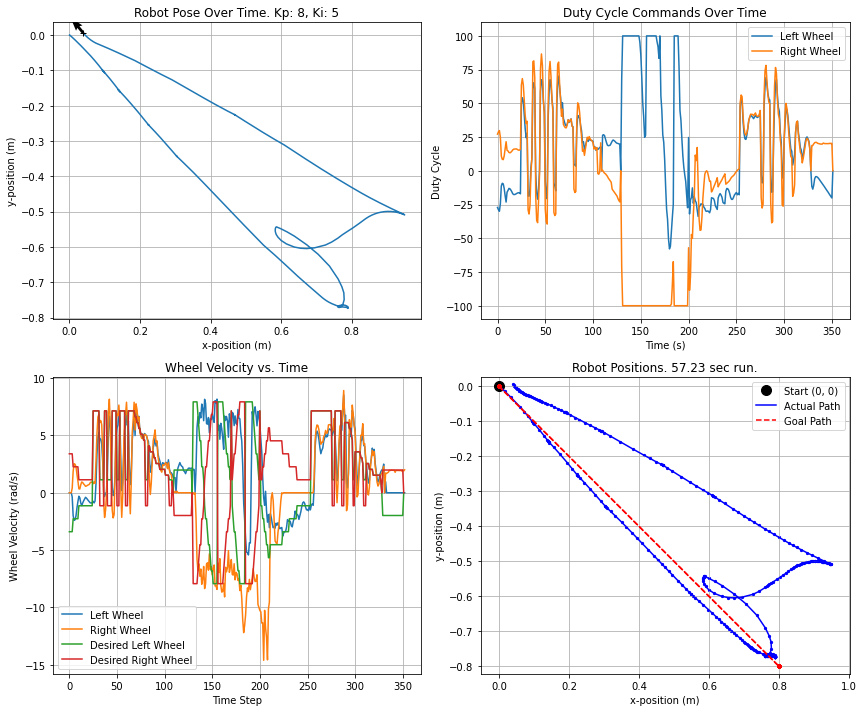

In [10]:
# To regenerat e the plot in a nice way, run this cell:
%matplotlib inline
plt.ion()  # Turn on interactive mode

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
update_plot(orchestrator, fig, axes)